# Tutorial 4 - Spatial Regression in Python

```{attention}
Finnish university students are encouraged to use the CSC Notebooks platform.<br/>
<a href="https://notebooks.csc.fi/#/blueprint/c54303e865294208ba1ef381332fd69b"><img alt="CSC badge" src="https://img.shields.io/badge/launch-CSC%20notebook-blue.svg" style="vertical-align:text-bottom"></a>

Others can follow the lesson interactively using Binder. Check the rocket icon on the top of this page.
```

```{admonition} Attribution
**Standing on the shoulders of giants**: This tutorial is based on excellent open source materials developed by Daniel Arribas-Bel (Uni. Liverpool) available in [here](http://darribas.org/gds_scipy16/ipynb_md/08_spatial_regression.html) (licensed with Creative Commons BY-NC-SA). Inspiration is also driven from Chapter 11 of the forthcoming book "Geographic Data Science with Python" by Rey, Arribas-Bel & Wolf which you can access from [here](https://geographicdata.science/book/notebooks/11_regression.html) (licensed with Creative Commons BY-NC-ND).
```

This notebook covers a brief and gentle introduction to spatial econometrics in Python. To do that, we will use a set of Austin properties listed in AirBnb.

The core idea of spatial econometrics is to introduce a formal representation of space into the statistical framework for regression. This can be done in many ways: by including predictors based on space (e.g. distance to relevant features), by splitting the datasets into subsets that map into different geographical regions (e.g. [spatial regimes](http://pysal.readthedocs.io/en/latest/library/spreg/regimes.html)), by exploiting close distance to other observations to borrow information in the estimation (e.g. [kriging](https://en.wikipedia.org/wiki/Kriging)), or by introducing variables that put in relation their value at a given location with those in nearby locations, to give a few examples. Some of these approaches can be implemented with standard non-spatial techniques, while others require bespoke models that can deal with the issues introduced. In this short tutorial, we will focus on the latter group. In particular, we will introduce some of the most commonly used methods in the field of spatial econometrics.

The example we will use to demonstrate this draws on hedonic house price modelling. This a well-established methodology that was developed by [Rosen (1974)](https://www.sonoma.edu/users/c/cuellar/econ421/rosen-hedonic.pdf) that is capable of recovering the marginal willingness to pay for goods or services that are not traded in the market. In other words, this allows us to put an implicit price on things such as living close to a park or in a neighborhood with good quality of air. In addition, since hedonic models are based on linear regression, the technique can also be used to obtain predictions of house prices.

## Prepare data

Before anything, let us load up the libraries we will use:

In [1]:
from pysal.model import spreg
from pysal.lib import weights
from pysal.explore import esda
import hvplot.pandas
from scipy import stats
import statsmodels.formula.api as sm
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from pyrosm import OSM, get_data
sns.set(style="whitegrid")

Let's read the Airbnb data and OSM data for Austin, Texas:

In [2]:
# Read listings
fp = "data/listings.csv"
data = pd.read_csv(fp)
data.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', '

<AxesSubplot:>

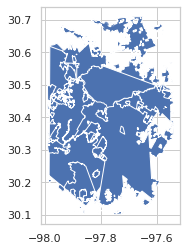

In [3]:
# Read OSM data - get administrative boundaries
osm = OSM(get_data("austin"))
boundaries = osm.get_boundaries()

# Let's check the boundaries on a map
boundaries.plot()

Let's convert the Airbnb data into GeoDataFrame based on the `longitude` and `latitude` columns and filter the data geographically based on Austing boundaries:

In [4]:
# Create a GeoDataFrame
data["geometry"] = gpd.points_from_xy(data["longitude"], data["latitude"])
data = gpd.GeoDataFrame(data, crs="epsg:4326")

# Filter geographically
data = gpd.sjoin(data, boundaries[["geometry"]])
data = data.reset_index(drop=True)

# Check the first rows
data.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,geometry,index_right
0,72635,https://www.airbnb.com/rooms/72635,20151107173015,2015-11-08,"3 Private Bedrooms, SW Austin",Conveniently located 10-15 from downtown in SW...,"We have three spare bedrooms, each with a quee...",Conveniently located 10-15 from downtown in SW...,none,Location and convenience are key. Easy access...,...,NaN,NaN,f,moderate,f,f,1,0.02,POINT (-97.88431 30.20282),14
1,5386323,https://www.airbnb.com/rooms/5386323,20151107173015,2015-11-07,Cricket Trailer,Rent this cool concept trailer that has everyt...,Rental arrangements for this trailer allows yo...,Rent this cool concept trailer that has everyt...,none,We're talking about wherever you'd like in the...,...,NaN,NaN,f,moderate,f,f,1,NaN,POINT (-97.90068 30.19941),14
2,8536913,https://www.airbnb.com/rooms/8536913,20151107173015,2015-11-08,Brand-New 3BR Austin Home,Brand-new 3BR/2BA Austin home with landscaped ...,Feel instantly at home at our brand new 3BR/2B...,Brand-new 3BR/2BA Austin home with landscaped ...,none,Entertainment and activities are plentiful her...,...,NaN,NaN,f,strict,f,f,2,NaN,POINT (-97.88832 30.16943),14
3,8542056,https://www.airbnb.com/rooms/8542056,20151107173015,2015-11-07,Private room & Bathroom.,15 minutes from Downtown & Zilker Park. Use of...,NaN,15 minutes from Downtown & Zilker Park. Use of...,none,NaN,...,NaN,NaN,f,flexible,f,f,1,NaN,POINT (-97.90744 30.18676),14
4,6385948,https://www.airbnb.com/rooms/6385948,20151107173015,2015-11-08,"S. Austin, convenient to MoPac",Private upstairs room with bath in far South A...,"In addition to the first bedroom, we have an a...",Private upstairs room with bath in far South A...,none,"Quiet, residential neighborhood that feels a l...",...,NaN,NaN,f,flexible,f,f,1,NaN,POINT (-97.92022 30.18770),14


Let's investigate our listings data on top of a map:

In [5]:
data.hvplot(geo=True, tiles="OSM", alpha=0.5, width=600, height=600, hover_cols=["name"])

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Longitude,Latitude]   (name)

## Baseline (nonspatial) regression

Before introducing explicitly spatial methods, we will run a simple linear regression model. This will allow us, on the one hand, set the main principles of hedonic modeling and how to interpret the coefficients, which is good because the spatial models will build on this; and, on the other hand, it will provide a baseline model that we can use to evaluate how meaningful the spatial extensions are.

Essentially, the core of a linear regression is to explain a given variable -the price of a listing $i$ on AirBnb ($P_i$)- as a linear function of a set of other characteristics we will collectively call $X_i$:

$$
\ln(P_i) = \alpha + \beta X_i + \epsilon_i
$$

For several reasons, it is common practice to introduce the price in logarithms, so we will do so here. Additionally, since this is a probabilistic model, we add an error term $\epsilon_i$ that is assumed to be well-behaved (i.i.d. as a normal).

For our example, we will consider the following set of explanatory features of each listed property:

In [6]:
explanatory_vars = ['host_listings_count', 'bathrooms', 'bedrooms', 'beds', 'guests_included']

Additionally, we are going to derive a new feature of a listing from the amenities variable. Let us construct a variable that takes 1 if the listed property has a pool and 0 otherwise:

In [7]:
def has_pool(a):
    if 'Pool' in a:
        return 1
    else:
        return 0
    
data['pool'] = data['amenities'].apply(has_pool)

Let's calculate the logarithmic value from the price. Let's first check our values:

In [8]:
data["price"].head()

0    $300.00
1     $99.00
2    $599.00
3    $100.00
4     $54.00
Name: price, dtype: object

As we can see, our values are represented as strings with a dollar sign. Before we can take a logarithmic value out of them, we need to remove the dollar sign and convert the values to floats:

In [9]:
# Remove dollar sign and the thousand separator (comma, e.g. 1000,000.00) and convert to float
data["price"] = data["price"].str.replace("$", '', regex=True).str.replace(",", "").astype(float)
data["log_price"] = np.log(data["price"] + 0.000001)

Do we have any missing values in our dependent or explanatory variables?

In [10]:
all_model_attributes = ["price"] + explanatory_vars
has_nans = False
for attr in all_model_attributes:
    if data[attr].hasnans:
        has_nans = True
print("Has missing values:", has_nans)

Has missing values: True


Okay, as we can see there are missing values, hence, let's remove them before continuing:

In [11]:
data = data.dropna(subset=all_model_attributes).copy()

To run the model, we can use the `spreg` module in `PySAL`, which implements a standard OLS routine, but is particularly well suited for regressions on spatial data. Also, although for the initial model we do not need it, let us build a spatial weights matrix that connects every observation to its 8 nearest neighbors. This will allow us to get extra diagnostics from the baseline model.

In [12]:
w = weights.KNN.from_dataframe(data, k=8)
w.transform = 'R'
w

/home/hentenka/miniconda3/envs/sustainability/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 6 disconnected components.
  warnings.warn(message)


At this point, we are ready to fit the regression:

In [13]:
m1 = spreg.OLS(data[['log_price']].values, data[explanatory_vars].values, 
                  name_y = 'log_price', name_x = explanatory_vars)

To get a quick glimpse of the results, we can print its summary:

In [14]:
print(m1.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :   log_price                Number of Observations:        9405
Mean dependent var  :      5.2091                Number of Variables   :           6
S.D. dependent var  :      0.9274                Degrees of Freedom    :        9399
R-squared           :      0.4135
Adjusted R-squared  :      0.4132
Sum squared residual:    4743.292                F-statistic           :   1325.2928
Sigma-square        :       0.505                Prob(F-statistic)     :           0
S.E. of regression  :       0.710                Log likelihood        :  -10126.208
Sigma-square ML     :       0.504                Akaike info criterion :   20264.416
S.E of regression ML:      0.7102                Schwarz criterion     :   20307.310

-----------------------------------------------------------------------------

Results are largely unsurprising, but nonetheless reassuring. Both an extra bedroom and an extra bathroom increase the final price around 30%. Accounting for those, an extra bed pushes the price about 2%. Neither the number of guests included nor the number of listings the host has in total have a significant effect on the final price.

Including a spatial weights object in the regression buys you an extra bit: the summary provides results on the diagnostics for spatial dependence. These are a series of statistics that test whether the residuals of the regression are spatially correlated, against the null of a random distribution over space. If the latter is rejected a key assumption of OLS, independently distributed error terms, is violated. Depending on the structure of the spatial pattern, different strategies have been defined within the spatial econometrics literature to deal with them. The main summary from the diagnostics for spatial dependence is that there is clear evidence to reject the null of spatial randomness in the residuals, hence an explicitly spatial approach is warranted.

## Spatially lagged exogenous regressors (`WX`)

The first and most straightforward way to introduce space is by **"spatially lagging" one of the explanatory variables**. Mathematically, this can be expressed as follows:

$$
\ln(P_i) = \alpha + \beta X_i + \delta \sum_j w_{ij} X'_i + \epsilon_i
$$

where $\ln(P_i)$ is our dependent variable (logarithmic price), $X'_i$ is a subset of $X_i$, although it could encompass all of the explanatory variables, and $w_{ij}$ is the $ij$-th cell of a spatial weights matrix $W$. Because $W$ assigns non-zero values only to spatial neighbors, if $W$ is row-standardized (customary in this context), then $\sum_j w_{ij} X'_i$ captures the average value of $X'_i$ in the surroundings of location $i$. This is what we call the *spatial lag* of $X_i$. Also, since it is a spatial transformation of an explanatory variable, the standard estimation approach -OLS- is sufficient: spatially lagging the variables does not violate any of the assumptions on which OLS relies.

Usually, we will want to spatially lag variables that we think may affect the price of a house in a given location. For example, one could think that pools represent a visual amenity. If that is the case, then listed properties surrounded by other properties with pools might, everything else equal, be more expensive. To calculate the number of pools surrounding each property, we can build an alternative weights matrix that we do not row-standardize:

In [15]:
# Create weigts
w_pool = weights.KNN.from_dataframe(data, k=8)
# Assign spatial lag based on the pool values
lagged = data.assign(w_pool=weights.spatial_lag.lag_spatial(w_pool, data['pool'].values))
lagged.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,geometry,index_right,pool,log_price,w_pool
0,72635,https://www.airbnb.com/rooms/72635,20151107173015,2015-11-08,"3 Private Bedrooms, SW Austin",Conveniently located 10-15 from downtown in SW...,"We have three spare bedrooms, each with a quee...",Conveniently located 10-15 from downtown in SW...,none,Location and convenience are key. Easy access...,...,moderate,f,f,1,0.02,POINT (-97.88431 30.20282),14,0,5.703782,2.0
1,5386323,https://www.airbnb.com/rooms/5386323,20151107173015,2015-11-07,Cricket Trailer,Rent this cool concept trailer that has everyt...,Rental arrangements for this trailer allows yo...,Rent this cool concept trailer that has everyt...,none,We're talking about wherever you'd like in the...,...,moderate,f,f,1,NaN,POINT (-97.90068 30.19941),14,0,4.595120,0.0
2,8536913,https://www.airbnb.com/rooms/8536913,20151107173015,2015-11-08,Brand-New 3BR Austin Home,Brand-new 3BR/2BA Austin home with landscaped ...,Feel instantly at home at our brand new 3BR/2B...,Brand-new 3BR/2BA Austin home with landscaped ...,none,Entertainment and activities are plentiful her...,...,strict,f,f,2,NaN,POINT (-97.88832 30.16943),14,0,6.395262,0.0
3,8542056,https://www.airbnb.com/rooms/8542056,20151107173015,2015-11-07,Private room & Bathroom.,15 minutes from Downtown & Zilker Park. Use of...,NaN,15 minutes from Downtown & Zilker Park. Use of...,none,NaN,...,flexible,f,f,1,NaN,POINT (-97.90744 30.18676),14,0,4.605170,0.0
4,6385948,https://www.airbnb.com/rooms/6385948,20151107173015,2015-11-08,"S. Austin, convenient to MoPac",Private upstairs room with bath in far South A...,"In addition to the first bedroom, we have an a...",Private upstairs room with bath in far South A...,none,"Quiet, residential neighborhood that feels a l...",...,flexible,f,f,1,NaN,POINT (-97.92022 30.18770),14,0,3.988984,1.0


And now we can run the model, which has the same setup as `m1`, with the exception that it includes the number of AirBnb properties with pools surrounding each house:

In [16]:
# Add pool to the explanatory variables
extended_vars = explanatory_vars + ["pool", "w_pool"]

m2 = spreg.OLS(lagged[['log_price']].values, lagged[extended_vars].values, 
               name_y = 'log_price', name_x = extended_vars)


In [17]:
print(m2.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :   log_price                Number of Observations:        9405
Mean dependent var  :      5.2091                Number of Variables   :           8
S.D. dependent var  :      0.9274                Degrees of Freedom    :        9397
R-squared           :      0.4160
Adjusted R-squared  :      0.4156
Sum squared residual:    4722.719                F-statistic           :    956.4067
Sigma-square        :       0.503                Prob(F-statistic)     :           0
S.E. of regression  :       0.709                Log likelihood        :  -10105.768
Sigma-square ML     :       0.502                Akaike info criterion :   20227.536
S.E of regression ML:      0.7086                Schwarz criterion     :   20284.728

-----------------------------------------------------------------------------

Results are largely consistent with the original model. Also, incidentally, the number of pools surrounding a property does not appear to have any significant effect on the price of a given property. This could be for a host of reasons: maybe AirBnb customers do not value the number of pools surrounding a property where they are looking to stay; but maybe they do but our dataset only allows us to capture the number of pools in *other* AirBnb properties, which is not necessarily a good proxy of the number of pools in the immediate surroundings of a given property.

## Spatially lagged endogenous regressors (`WY`)

In a similar way to how we have included the spatial lag, one could think the prices of houses surrounding a given property also enter its own price function. In math terms, this implies the following:

$$
\ln(P_i) = \alpha + \lambda \sum_j w_{ij} \ln(P_i) + \beta X_i + \epsilon_i
$$

This is essentially what we call a *spatial lag* model in spatial econometrics. Two calls for caution:

1. Unlike before, this specification *does* violate some of the assumptions on which OLS relies. In particular, it is including an endogenous variable $\ln(P_i)$ on the right-hand side. This means we need a new estimation method to obtain reliable coefficients. The technical details of this go well beyond the scope of this tutorial. But we can offload those to `PySAL` and use the `GM_Lag` class, which implements the state-of-the-art approach to estimate this model.
1. A more conceptual *gotcha*: you might be tempted to read the equation above as the effect of the price in neighboring locations $j$ on that of location $i$. This is not exactly the exact interpretation. Instead, we need to realize this is all assumed to be a "joint decission": rather than some houses setting their price first and that having a subsequent effect on others, what the equation models is an interdependent process by which each owner sets her own price *taking into account* the price that will be set in neighboring locations. This might read a bit like a technical subtlety and, to some extent, it is; but it is important to keep it in mind when you are interpreting the results.

Let us see how you would run this using `PySAL`:

In [18]:
variables = explanatory_vars + ["pool"]
m3 = spreg.GM_Lag(data[['log_price']].values, data[variables].values, 
                  w=w,
                  name_y = 'ln(price)', name_x = variables)

In [19]:
print(m3.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :   ln(price)                Number of Observations:        9405
Mean dependent var  :      5.2091                Number of Variables   :           8
S.D. dependent var  :      0.9274                Degrees of Freedom    :        9397
Pseudo R-squared    :      0.4528
Spatial Pseudo R-squared:  0.4164

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT       3.5328351       0.1106839      31.9182262       0.0000000
 host_listings_count      -0.0000774       0.0001290      -0.6001854       0.5483827
           bathrooms       0.2727659       0.0147162      1

As we can see, results are again very similar in all the other variable. It is also very clear that the estimate of the spatial lag of price is statistically significant. This points to evidence that there are processes of spatial interaction between property owners when they set their price.

## Prediction performance of spatial models

Even if we are not interested in the interpretation of the model to learn more about how alternative factors determine the price of an AirBnb property, spatial econometrics can be useful. In a purely predictive setting, the use of explicitly spatial models is likely to improve accuracy in cases where space plays a key role in the data generating process. To have a quick look at this issue, we can use the mean squared error (MSE), a standard metric of accuracy in the machine learning literature, to evaluate whether explicitly spatial models are better than traditional, non-spatial ones:

In [20]:
from sklearn.metrics import mean_squared_error as mse

mses = pd.Series({'OLS': mse(data["log_price"], m1.predy.flatten()), \
                  'OLS+W': mse(data["log_price"], m2.predy.flatten()), \
                  'Lag': mse(data["log_price"], m3.predy_e)
                    })
mses.sort_values()

Lag      0.501873
OLS+W    0.502150
OLS      0.504337
dtype: float64

We can see that the inclusion of the number of surrounding pools slightly reduces the MSE, and the inclusion of the spatial lag of price improves the accuracy of the model even further.